In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import matplotlib.pyplot as plt
!pip install torchinfo
from torchinfo import summary
import numpy as np
import os
import json
import random
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR


import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Fonction d'aide

In [3]:
def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

In [4]:
def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

##### DOn't keep

In [ ]:
class DropPath(nn.Module):
    def __init__(self, drop_prob=0.):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0.0 or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        # shape = [B, 1, 1,...] so broadcast along all other dims
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()  # binarize
        output = x / keep_prob * random_tensor
        return output


# Patch Partition

In [5]:
class PatchPartition(nn.Module):
  # On passe d'une image WxHx3 à W/4xH/4x96
    def __init__(self, in_channels=3, patch_size=4, embed_dim=96):
        """
        in_channels : 3 pcq RGB
        patch_size: size  patch (4 pcq /4).
        embed_dim: dimension embedding (C = 96)
        """
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        """
        (B, C, H, W)
        B = batch_size, C = channels, H = height, W = width
        Et va return
        (B, H/patch_size * W/patch_size, embed_dim)
        """
        x = self.projection(x)
        x = x.permute(0, 2, 3, 1)
        B, Hp, Wp, C = x.shape
        x = x.view(B, Hp * Wp, C)
        return x

##### To keep if don't work

In [ ]:
class PatchPartition2(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

# Linear Embedding

In [6]:
class LinearEmbedding(nn.Module):
    def __init__(self, in_features, embed_dim):
        """
        in_features: dismension de l'input
        embed_dim: dimension output (target) donc (C)
        """
        super().__init__()
        self.linear_proj = nn.Linear(in_features, embed_dim)

    def forward(self, x):
        """
        (B, H', W', C)
        Et va return
        (B, H', W', embed_dim)
        embed dim : "A linear embedding layer is applied on this raw-valued feature to project it to an arbitrary dimension (denoted as C )"
        On doit choisir C. Test avec 96 ?
        """
        B, H, W, C = x.shape
        x = x.view(B, -1, C)  #(B, H' * W', in_features)
        x = self.linear_proj(x)  #(B, H' * W', embed_dim)
        x = x.view(B, H, W, -1)  #(B, H', W', embed_dim)
        return x

# PatchMerging

In [7]:
class PatchMerging(nn.Module):
    def __init__(self, in_channels, dim):
        super().__init__()
        self.originale_dim = in_channels
        self.dim =dim
        self.LayerNorm = nn.LayerNorm( 4 * dim)  # Normalistation pour 4 dimentions
        self.reduction = nn.Linear(4*dim, 2*dim, bias=False) # Réduction de C

    def forward(self, x):
      Height,Width = self.originale_dim
      B, L, C = x.shape
      x = x.view(B, Height, Width, C)

      # On prends les 4 blocks En haut à gauche, bas gauche, haut droite, bas droite
      # Prendre une ligne/colonne sur 2 permet de faire une réduction spaciale
      B1 = x[:, 0::2, 0::2,:]
      B2 = x[:, 1::2, 0::2,:]
      B3 = x[:, 0::2, 1::2,:]
      B4 = x[:, 1::2, 1::2,:]

      x = torch.cat([B1, B2, B3, B4], dim=-1)  # On merge pour avoir la sortie qu'on veut
      x = x.view(B, -1, 4 * C)  #Reshape en (B, H/4, W/4, 4*C) Avec B = Batch Size, H = Height, W = Width, C = facteur inconnue
      # -1 => Laisse Pytorch trouver lui même la taille du tenseur

      x = self.LayerNorm(x) # Normalisation sur les 4*C
      x = self.reduction(x) # Réduction pour aller de 4*C à 2 *C

      return x


##### To keep if don't work

In [ ]:
class PatchMerging2(nn.Module):
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

# Swin Transformer Block

### MLP

In [8]:
class MLP(nn.Module):
  def __init__(self, in_features, hidden_features, out_features, drop):
    super().__init__()
    out_features = out_features
    hidden_features = hidden_features
    in_features = in_features
    drop = drop
    self.fc1 = nn.Linear(in_features, hidden_features)
    self.gelu = nn.GELU()
    self.fc2 = nn.Linear(hidden_features, out_features)
    #Dropout non dit dans le papier de recherche
    self.dropout = nn.Dropout(drop)

  def forward(self, x):
    x = self.fc1(x)
    x = self.gelu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.dropout(x)
    return x

### Window-based Multi-Head Self-Attention

In [9]:
import torch
import torch.nn as nn

class WMSA(nn.Module):
    def __init__(self, dim, window_size, num_heads):
        #On a a faire le "relative position bias"
        #Et le mask si on a shifted windows
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5

        #init l'attnetion Q K V
        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.proj = nn.Linear(dim, dim)
        self.softmax = nn.Softmax(dim=-1)

        # Relative position index + bias table
        #On calcul le (dx, dy) (position relative) d'un patch pour tout les patchs
        coords_h = torch.arange(window_size[0])
        coords_w = torch.arange(window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))
        coords_flatten = coords.flatten(1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :] #On a donc (2, wh*ww, wh*ww)
        relative_coords = relative_coords.permute(1, 2, 0).contiguous() #ici (wh*ww, wh*ww, 2)
        relative_coords[:, :, 0] += window_size[0] - 1
        relative_coords[:, :, 1] += window_size[1] - 1
        relative_coords[:, :, 0] *= (2 * window_size[1] - 1)
        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)
        self.relative_position_bias_table = nn.Parameter(torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))

    def forward(self, x, mask=None):
        """
        x: (B_, N, C)
        mask: shape (nW, N, N) for shifted windows, or None if not shifted
        """
        B_, N, C = x.shape
        # 1) qkv
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]







        q = q * self.scale
        attn = q @ k.transpose(-2, -1)

        # Ajoute le relative bias
        bias_table = self.relative_position_bias_table
        index = self.relative_position_index.view(-1)
        relative_position_bias = bias_table[index].view(N, N, self.num_heads)
        relative_position_bias = relative_position_bias.permute(2, 0, 1)
        attn = attn + relative_position_bias.unsqueeze(0)

        #On fait le mask, donc on enleve les liens lors du shift avec les immage d'arrivé à coté
        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N)
            attn = attn + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)

        attn = self.softmax(attn)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        return x


##### A garder si jamais marche pas

In [ ]:
class WMSA(nn.Module):
  def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
    super().__init__()
    self.dim = dim
    self.window_size = window_size
    self.num_heads = num_heads
    self.scale = (dim // num_heads) ** -0.5

    self.qkv = nn.Linear(dim, dim * 3, bias=True)
    self.proj = nn.Linear(dim, dim)
    self.softmax = nn.Softmax(dim=-1)
    self.attn_drop = nn.Dropout(attn_drop)
    self.proj_drop = nn.Dropout(proj_drop)

    coords_h = torch.arange(self.window_size[0])
    coords_w = torch.arange(self.window_size[1])
    coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
    coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
    relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
    relative_coords[:, :, 1] += self.window_size[1] - 1
    relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
    relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
    self.register_buffer("relative_position_index", relative_position_index)

    self.relative_position_bias_table = nn.Parameter(torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))

  def forward(self, x, mask=None):
    B_, N, C = x.shape
    qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
    q, k, v = qkv[0], qkv[1], qkv[2]
    q = q * self.scale
    attn = (q @ k.transpose(-2, -1))
    relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
        self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
    relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
    attn = attn + relative_position_bias.unsqueeze(0)

    if mask is not None:
      nW = mask.shape[0]
      attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
      attn = attn.view(-1, self.num_heads, N, N)
      attn = self.softmax(attn)
    else:
      attn = self.softmax(attn)

    attn = self.attn_drop(attn)

    x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
    x = self.proj(x)
    x = self.proj_drop(x)
    return x

## Swin Transformer Block

In [10]:
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0, mlp_ratio=4., norm_layer=nn.LayerNorm,):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio


        #La premier normalisation
        self.norm1 = norm_layer(dim)




        #Le window multi head self attention on l'initialise
        self.attn = WMSA(dim, window_size=(window_size, window_size), num_heads=num_heads)
        #Un drop path ?
        self.drop_path = nn.Identity()

        #La deuxieme normalisa  tion
        self.norm2 = norm_layer(dim)



        #Le MLP
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, out_features=dim, drop=0.1)


        #Pré calcule du mash d'attentino
        if self.shift_size > 0:
            self.attn_mask = self.create_attn_mask(self.input_resolution)
        else:
            self.attn_mask = None




    def create_attn_mask(self, input_resolution):
        H, W = input_resolution
        mask = torch.zeros((1, H, W, 1), dtype=torch.int32)
        h_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                mask[:, h, w, :] = cnt
                cnt += 1


        mask_windows = window_partition(mask, self.window_size)
        mask_windows = mask_windows.view(-1, self.window_size**2)

        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        #Zone different ou non
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0))
        attn_mask = attn_mask.masked_fill(attn_mask == 0, float(0.0))

        self.register_buffer("attn_mask", attn_mask, persistent=False)
        return attn_mask

    def forward(self, x):
        B, L, C = x.shape
        H, W = self.input_resolution
        assert L == H * W, "Wrong size"

        #Normalisation
        shortcut = x
        x = self.norm1(x).view(B, H, W, C)



        #Le shift window
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x


        #Decoupage des fenetres
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = x_windows.view(-1, self.window_size**2, C)

        #attentino
        attn_windows = self.attn(x_windows, mask=self.attn_mask)






        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        x = x.view(B, H*W, C)
        x = shortcut + self.drop_path(x)



        #MLP
        shortcut = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = shortcut + self.drop_path(x)

        return x


##### A garder si jamais marche pas

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# We assume you have these already:
# - window_partition
# - window_reverse
# - WMSA
# - MLP

class SwinTransformerBlock(nn.Module):
    r"""
    Swin Transformer Block:
      - Window-based (or Shifted Window) Multi-head Self-Attention
      - MLP
      - Residual connections
      - LayerNorm before each block (pre-norm)
    """
    def __init__(
        self,
        dim,                  # Number of input channels (C)
        input_resolution,     # (H, W)
        num_heads,
        window_size=7,
        shift_size=0,
        mlp_ratio=4.,
        qkv_bias=True,
        qk_scale=None,
        drop=0.,
        attn_drop=0.,
        drop_path=0.,
        norm_layer=nn.LayerNorm
    ):
        super().__init__()

        self.dim = dim
        self.input_resolution = input_resolution  # (H, W)
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        # Ensure shift_size is less than window_size
        assert 0 <= self.shift_size < self.window_size, \
            "shift_size must be in [0, window_size)"

        self.norm1 = norm_layer(dim)
        self.attn = WMSA(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop
        )

        # For the stochastic depth / drop path, you can use a nn.Identity() if drop_path = 0
        self.drop_path = nn.Identity()  # or timm's DropPath(drop_path) if available

        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            out_features=dim,
            drop=drop
        )

        # Create attention mask if we are using shifted windows
        if self.shift_size > 0:
            self.attn_mask = self.calculate_mask(input_resolution)
        else:
            self.attn_mask = None

    def calculate_mask(self, input_resolution):
        """
        Generate mask for SW-MSA.
        Mask shape: (num_windows, window_size^2, window_size^2).
        """
        H, W = input_resolution
        img_mask = torch.zeros((1, H, W, 1))  # shape (1, H, W, 1)

        # We will mark the regions in [0:-wsize, -wsize:-shift, -shift:]
        h_slices = (
            slice(0, -self.window_size),
            slice(-self.window_size, -self.shift_size),
            slice(-self.shift_size, None)
        )
        w_slices = (
            slice(0, -self.window_size),
            slice(-self.window_size, -self.shift_size),
            slice(-self.shift_size, None)
        )

        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        # Now we partition the mask into windows
        mask_windows = window_partition(img_mask, self.window_size)  # (nW, window_size, window_size, 1)
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)

        # mask_windows: (nW, ws*ws)
        # We compute an attention mask by subtracting (nW,1) with (nW,1) -> shape (nW, ws*ws, ws*ws)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        # Where the difference != 0 => different windows => mask out
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        self.register_buffer("attn_mask", attn_mask, persistent=False)

        return attn_mask

    def forward(self, x):
        """
        x: Tensor shape (B, H*W, C).
        """
        B, L, C = x.shape
        H, W = self.input_resolution
        assert L == H * W, "Input feature has wrong size"

        # ----- 1) Attention block -----
        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # Shift if needed
        if self.shift_size > 0:
            # (B, H, W, C) -> shift by -shift_size in height and width
            shifted_x = torch.roll(
                x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2)
            )
        else:
            shifted_x = x

        # Partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # (nW*B, window_size, window_size, C)
        # Flatten for WMSA
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)

        # WMSA or SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        # Reshape back
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # (B, H, W, C)

        # Reverse shift if needed
        if self.shift_size > 0:
            x = torch.roll(
                shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2)
            )
        else:
            x = shifted_x

        x = x.view(B, H * W, C)

        # Skip connection
        x = shortcut + self.drop_path(x)

        # ----- 2) MLP block -----
        shortcut = x
        x = self.norm2(x)
        x = self.mlp(x)

        # Second skip connection
        x = shortcut + self.drop_path(x)

        return x


## Basic

In [11]:
class BlockLayer(nn.Module):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size=7, mlp_ratio=4., use_shift=True, downsample=None, norm_layer=nn.LayerNorm,):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.window_size = window_size
        self.use_shift = use_shift


        self.blocks = nn.ModuleList()
        for i in range(depth):
            # calcul shift
            shift = window_size // 2 if (use_shift and i % 2 == 1) else 0
            block = SwinTransformerBlock(dim=dim, input_resolution=input_resolution, num_heads=num_heads, window_size=window_size, shift_size=shift, mlp_ratio=mlp_ratio, norm_layer=norm_layer)
            self.blocks.append(block)

        #PatchMerging
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x


##### A garder si jamais marche pas

In [ ]:
class BasicLayer(nn.Module):
    """
    One stage of the Swin Transformer, repeated for `depth` blocks,
    with an optional PatchMerging at the end.
    """
    def __init__(
        self,
        dim,                 # Feature dimension in this stage
        input_resolution,    # (H, W)
        depth,               # Number of SwinTransformerBlocks
        num_heads,
        window_size=7,
        mlp_ratio=4.,
        qkv_bias=True,
        qk_scale=None,
        drop=0.,
        attn_drop=0.,
        drop_path=0.,
        # A list or float for drop_path can also be used to vary drop_path across blocks
        norm_layer=nn.LayerNorm,
        downsample=None,     # PatchMerging2 if we want to downsample after stage
        use_shift=True,      # Whether to use window shifting in alternate blocks
    ):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.window_size = window_size
        self.use_shift = use_shift

        self.blocks = nn.ModuleList()
        for i in range(depth):
            # shift_size alternates between 0 and window_size//2 if we follow the paper
            shift_size = 0
            if self.use_shift and (i % 2 == 1):
                shift_size = window_size // 2

            block = SwinTransformerBlock(
                dim=dim,
                input_resolution=input_resolution,
                num_heads=num_heads,
                window_size=window_size,
                shift_size=shift_size,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop,
                attn_drop=attn_drop,
                drop_path=drop_path,  # could be a list if you want per-block
                norm_layer=norm_layer
            )
            self.blocks.append(block)

        # Downsample layer (PatchMerging) if needed, e.g. after stages 0,1,2 in a 4-stage network
        self.downsample = downsample(
            input_resolution, dim=dim
        ) if downsample is not None else None

    def forward(self, x):
        # x: (B, H*W, C)
        for blk in self.blocks:
            x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x


## Swin Transformer

In [12]:
class SwinTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000, embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24], window_size=7, mlp_ratio=4., use_shift=True,):
        super().__init__()
        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim

        #Patch Partition au debut
        self.patch_embed = PatchPartition(in_channels=in_chans, patch_size=patch_size, embed_dim=embed_dim)
        H_ = img_size // patch_size
        W_ = img_size // patch_size
        self.patches_resolution = (H_, W_)
        self.pos_drop = nn.Dropout(p=0.0)




        #On fait les stages en fonction du depth
        self.layers = nn.ModuleList()
        dim_current = embed_dim
        H, W = self.patches_resolution
        for i_layer in range(self.num_layers):
            stage = BlockLayer(dim=dim_current, input_resolution=(H, W), depth=depths[i_layer], num_heads=num_heads[i_layer], window_size=window_size, mlp_ratio=mlp_ratio, use_shift=use_shift, downsample=PatchMerging if (i_layer < self.num_layers - 1) else None)
            self.layers.append(stage)
            if i_layer < self.num_layers - 1:
                H, W = H // 2, W // 2
                dim_current *= 2
        self.norm = nn.LayerNorm(dim_current)
        self.head = nn.Linear(dim_current, num_classes) if num_classes > 0 else nn.Identity()




    def forward(self, x):
        x = self.patch_embed(x)
        x = self.pos_drop(x)
        for layer in self.layers:
            x = layer(x)
        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.head(x)
        return x


##### A garder si jamais marche pas

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SwinTransformer(nn.Module):
    def __init__(
        self,
        img_size=224,
        patch_size=4,
        in_chans=3,
        num_classes=1000,
        embed_dim=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7,
        mlp_ratio=4.,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.,
        attn_drop_rate=0.,
        drop_path_rate=0.1,
        norm_layer=nn.LayerNorm,
        use_shift=True,  # Whether to use shifted windows
    ):
        """
        img_size: input image size
        patch_size: patch size for patch embedding
        in_chans: input channels
        num_classes: # of classes for classification head
        embed_dim: base embedding dimension
        depths: list of #SwinTransformerBlock in each stage
        num_heads: list of heads in each stage
        window_size: window size
        mlp_ratio: ratio for MLP hidden dim
        qkv_bias, qk_scale: for attention
        drop_rate, attn_drop_rate: dropout rates
        drop_path_rate: stochastic depth rate
        norm_layer: e.g. nn.LayerNorm
        use_shift: if True, use alternating window shift
        """
        super().__init__()
        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))  # final stage dimension

        # 1) Patch Embedding
        self.patch_embed = PatchPartition(
            in_channels=in_chans,
            patch_size=patch_size,
            embed_dim=embed_dim
        )
        # (B, H'*W', C) where H' = img_size/patch_size, W' = img_size/patch_size

        # 2) Absolute position embedding (Optional)
        # Not always used in Swin – the official code does not do "absolute" embedding,
        # it uses "relative positions" within WMSA. So we can skip or do it optionally.

        self.patches_resolution = self.patch_embed.patches_resolution  # (H', W')
        # e.g. for img_size=224, patch_size=4 => H'=56, W'=56

        # 3) Dropout on embeddings if needed
        self.pos_drop = nn.Dropout(p=drop_rate)

        # Stochastic depth schedule
        # we can split drop_path_rate across all blocks
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        # 4) Build Stages
        self.layers = nn.ModuleList()
        dim_current = embed_dim
        H, W = self.patches_resolution

        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=dim_current,
                input_resolution=(H, W),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer+1])],
                  # pass the chunk of drop_path for this stage
                norm_layer=norm_layer,
                downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                use_shift=use_shift,
            )
            self.layers.append(layer)

            # After each stage (except last), resolution is halved
            if i_layer < self.num_layers - 1:
                H, W = (H // 2, W // 2)
                dim_current = dim_current * 2  # dimension is doubled

        # 5) Norm layer after all stages
        self.norm = norm_layer(dim_current)

        # 6) Classification head
        self.head = nn.Linear(dim_current, num_classes) if num_classes > 0 else nn.Identity()

    def forward(self, x):
        # x: (B, C, H, W)
        # Step 1: Patch embedding
        x = self.patch_embed(x)   # (B, H'*W', C)
        x = self.pos_drop(x)

        # Step 2: Forward through each stage
        for layer in self.layers:
            x = layer(x)

        # x is now (B, final_H * final_W, final_dim)
        # final_H = H'/2^(num_layers-1)

        # Step 3: Norm
        x = self.norm(x)  # (B, N, C_final)

        # Typically for classification, we do an average pool across the spatial tokens:
        x = x.mean(dim=1)  # (B, C_final)

        # Step 4: Head
        x = self.head(x)   # (B, num_classes)
        return x


## Model

In [13]:
model = SwinTransformer(img_size=224, patch_size=4, in_chans=3, num_classes=1000, embed_dim=96, depths=[2,2,6,2], num_heads=[3,6,12,24], window_size=7, mlp_ratio=4., use_shift=True,)

model = model.to(device)

summary(model, input_size=(1, 3, 224, 224), device=str(device))


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Layer (type:depth-idx)                             Output Shape              Param #
SwinTransformer                                    [1, 1000]                 --
├─PatchPartition: 1-1                              [1, 3136, 96]             --
│    └─Conv2d: 2-1                                 [1, 96, 56, 56]           4,704
├─Dropout: 1-2                                     [1, 3136, 96]             --
├─ModuleList: 1-3                                  --                        --
│    └─BlockLayer: 2-2                             [1, 784, 192]             --
│    │    └─ModuleList: 3-1                        --                        224,694
│    │    └─PatchMerging: 3-2                      [1, 784, 192]             74,496
│    └─BlockLayer: 2-3                             [1, 196, 384]             --
│    │    └─ModuleList: 3-3                        --                        891,756
│    │    └─PatchMerging: 3-4                      [1, 196, 384]             296,448
│    └─BlockL

# Dataset

In [14]:
!pip install kaggle

In [15]:
import kagglehub

path = kagglehub.dataset_download("ambityga/imagenet100")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ambityga/imagenet100/versions/8


In [16]:
ROOT_DATASET = "/root/.cache/kagglehub/datasets/ambityga/imagenet100/versions/8"

with open(os.path.join(ROOT_DATASET, "Labels.json"), "r") as f:
    labels_map = json.load(f)

train_image_paths = []
train_labels = []
train_folders = ["train.X1", "train.X2", "train.X3", "train.X4"]
for folder_name in train_folders:
    folder_path = os.path.join(ROOT_DATASET, folder_name)
    for class_dir in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_dir)
        if not os.path.isdir(class_folder):
            continue
        for img_name in os.listdir(class_folder):
            if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(class_folder, img_name)
                train_image_paths.append(img_path)
                train_labels.append(class_dir)


val_image_paths = []
val_labels = []
val_folder = os.path.join(ROOT_DATASET, "val.X")
for class_dir in os.listdir(val_folder):
    class_folder = os.path.join(val_folder, class_dir)
    if not os.path.isdir(class_folder):
        continue
    for img_name in os.listdir(class_folder):
        if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(class_folder, img_name)
            val_image_paths.append(img_path)
            val_labels.append(class_dir)
print(f"Number of train images: {len(train_image_paths)}")
print(f"Number of val images: {len(val_image_paths)}")

Number of train images: 130000
Number of val images: 5000


In [17]:
val_data = list(zip(val_image_paths, val_labels))
random.shuffle(val_data)

n_val = len(val_data)
n_test = int(0.1 * n_val)
test_data = val_data[:n_test]
val_data = val_data[n_test:]

val_image_paths, val_labels = zip(*val_data)
test_image_paths, test_labels = zip(*test_data)

print("Final val set size:", len(val_image_paths))
print("Final test set size:", len(test_image_paths))


Final val set size: 4500
Final test set size: 500


In [18]:
class ImageNetLikeDataset(Dataset):
    def __init__(self, image_paths, labels, class_to_idx, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        label_name = self.labels[index]
        label_idx = self.class_to_idx[label_name]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label_idx


In [19]:
all_classes = sorted(set(train_labels + list(val_labels) + list(test_labels)))
class_to_idx = {cname: i for i, cname in enumerate(all_classes)}

In [20]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

transform_train = transforms.Compose([transforms.Resize((224, 224)), transforms.RandomHorizontalFlip(), transforms.ColorJitter(0.4, 0.4, 0.4, 0.1), transforms.ToTensor(), transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),])
transform_eval = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),])
transform_test = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),])

train_dataset = ImageNetLikeDataset(image_paths=train_image_paths, labels=train_labels, class_to_idx=class_to_idx, transform=transform_train)
val_dataset = ImageNetLikeDataset(image_paths=val_image_paths, labels=val_labels, class_to_idx=class_to_idx, transform=transform_eval)
test_dataset = ImageNetLikeDataset(image_paths=test_image_paths, labels=test_labels, class_to_idx=class_to_idx, transform=transform_eval)

print("Train dataset size:", len(train_dataset))
print("Val dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

num_classes = len(class_to_idx)

Train dataset size: 130000
Val dataset size: 4500
Test dataset size: 500


In [21]:
batch_size = 256
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [22]:
print("Train dataset size:", len(train_dataset))
print("Val dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))
print("Number of classes:", len(train_dataset.class_to_idx))

from collections import Counter


train_targets = [train_dataset.class_to_idx[label_name] for label_name in train_dataset.labels]
class_counts = Counter(train_targets)
print("Train Class Distribution (class_index -> count):")
for cls_idx, cnt in class_counts.most_common():
    print(f"Class {cls_idx}: {cnt}")

Train dataset size: 130000
Val dataset size: 4500
Test dataset size: 500
Number of classes: 100
Train Class Distribution (class_index -> count):
Class 9: 1300
Class 0: 1300
Class 75: 1300
Class 29: 1300
Class 20: 1300
Class 59: 1300
Class 4: 1300
Class 90: 1300
Class 53: 1300
Class 73: 1300
Class 31: 1300
Class 2: 1300
Class 55: 1300
Class 82: 1300
Class 62: 1300
Class 23: 1300
Class 88: 1300
Class 83: 1300
Class 93: 1300
Class 65: 1300
Class 74: 1300
Class 41: 1300
Class 78: 1300
Class 61: 1300
Class 96: 1300
Class 32: 1300
Class 66: 1300
Class 33: 1300
Class 43: 1300
Class 51: 1300
Class 48: 1300
Class 49: 1300
Class 50: 1300
Class 7: 1300
Class 39: 1300
Class 99: 1300
Class 27: 1300
Class 79: 1300
Class 92: 1300
Class 46: 1300
Class 98: 1300
Class 10: 1300
Class 8: 1300
Class 95: 1300
Class 37: 1300
Class 94: 1300
Class 35: 1300
Class 15: 1300
Class 13: 1300
Class 1: 1300
Class 80: 1300
Class 87: 1300
Class 89: 1300
Class 30: 1300
Class 63: 1300
Class 77: 1300
Class 36: 1300
Class 4

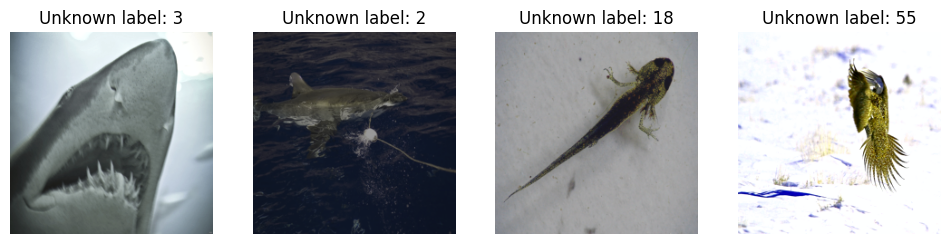

In [23]:
images, labels = next(iter(train_loader))
images = images[:4]
labels = labels[:4]

import numpy as np

def unnorm(img):
    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    img = img.cpu().numpy().transpose(1, 2, 0)
    img = (img * std + mean).clip(0, 1)
    return img
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axs[i].imshow(unnorm(images[i]))
    label_index = labels[i].item()
    if label_index in train_dataset.class_to_idx:
        axs[i].set_title(train_dataset.class_to_idx[label_index])
    else:
        axs[i].set_title(f"Unknown label: {label_index}")
    axs[i].axis('off')
plt.show()

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SwinTransformer(img_size=224, patch_size=4, in_chans=3, num_classes=1000, embed_dim=96, depths=[2,2,6,2], num_heads=[3,6,12,24], window_size=7, mlp_ratio=4., use_shift=True,).to(device)


Using device: cuda


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)

num_epochs = 75
warmup_epochs = 5

def lr_schedule(epoch):
    if epoch < warmup_epochs:
        return float(epoch) / float(warmup_epochs)
    else:
        progress = float(epoch - warmup_epochs) / float(num_epochs - warmup_epochs)
        return 0.5 * (1.0 + np.cos(np.pi * progress))


scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_schedule)

In [27]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

best_val_acc = 0.0

patience = 10
epochs_no_improve = 0

for epoch in range(num_epochs):
    #Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total
    scheduler.step()

    #Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100.0 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        checkpoint_path = "/content/drive/MyDrive/swin_best.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"  [*] Best model saved to: /content/drive/MyDrive/swin_best.pth")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"  [*] No improvement for {epochs_no_improve} epochs.")


    if epochs_no_improve >= patience:
        print(f"Early stopping triggered. Best Val Acc: {best_val_acc:.2f}%")
        break

Epoch [1/75] Train Loss: 7.0539, Train Acc: 0.11% | Val Loss: 7.0637, Val Acc: 0.09%
  [*] Best model saved to: /content/drive/MyDrive/swin_best.pth
Epoch [2/75] Train Loss: 4.7374, Train Acc: 6.39% | Val Loss: 4.2029, Val Acc: 15.51%
  [*] Best model saved to: /content/drive/MyDrive/swin_best.pth
Epoch [3/75] Train Loss: 3.9055, Train Acc: 21.02% | Val Loss: 3.4600, Val Acc: 30.80%
  [*] Best model saved to: /content/drive/MyDrive/swin_best.pth
Epoch [4/75] Train Loss: 3.3572, Train Acc: 33.33% | Val Loss: 3.1380, Val Acc: 39.38%
  [*] Best model saved to: /content/drive/MyDrive/swin_best.pth
Epoch [5/75] Train Loss: 3.0602, Train Acc: 40.67% | Val Loss: 2.9632, Val Acc: 43.11%
  [*] Best model saved to: /content/drive/MyDrive/swin_best.pth
Epoch [6/75] Train Loss: 2.8736, Train Acc: 45.41% | Val Loss: 2.8727, Val Acc: 46.47%
  [*] Best model saved to: /content/drive/MyDrive/swin_best.pth
Epoch [7/75] Train Loss: 2.6794, Train Acc: 50.54% | Val Loss: 2.7202, Val Acc: 50.20%
  [*] Best

In [28]:
best_model_path = "/content/drive/MyDrive/swin_best.pth"
model.load_state_dict(torch.load(best_model_path))
model.eval()

test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, pred = outputs.max(dim=1)
        test_correct += (pred == labels).sum().item()
        test_total += labels.size(0)

test_acc = 100.0 * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}% on {test_total} images.")

<ipython-input-28-97674e276fe8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 69.20% on 500 images.


## Dataset petit de test

In [ ]:
!pip install kaggle

In [ ]:
import kagglehub

path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2


In [ ]:
cards_csv = pd.read_csv("/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/cards.csv")
print(f"File shape: {cards_csv.shape}\n")
print(f"Data columns: {cards_csv.columns}\n")

data_dir = "/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/"

card_path = os.path.join(data_dir, 'cards.csv')

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
valid_dir = os.path.join(data_dir, 'valid')



File shape: (8155, 5)

Data columns: Index(['class index', 'filepaths', 'labels', 'card type', 'data set'], dtype='object')



In [ ]:

#print(f"\t######################## Train Data Sample ########################\n")
train_sample = cards_csv[cards_csv['data set'] == 'train'].sample(n=10)
#display(train_sample)
#print("\n\n")

#print(f"\t######################## Test Data Sample ########################\n")
test_sample = cards_csv[cards_csv['data set'] == 'test'].sample(n=10)
#display(train_sample)
#print("\n\n")

#print(f"\t######################## Validation Data Sample ########################\n")
valid_sample = cards_csv[cards_csv['data set'] == 'valid'].sample(n=10)
#display(valid_sample)
#print("\n\n")

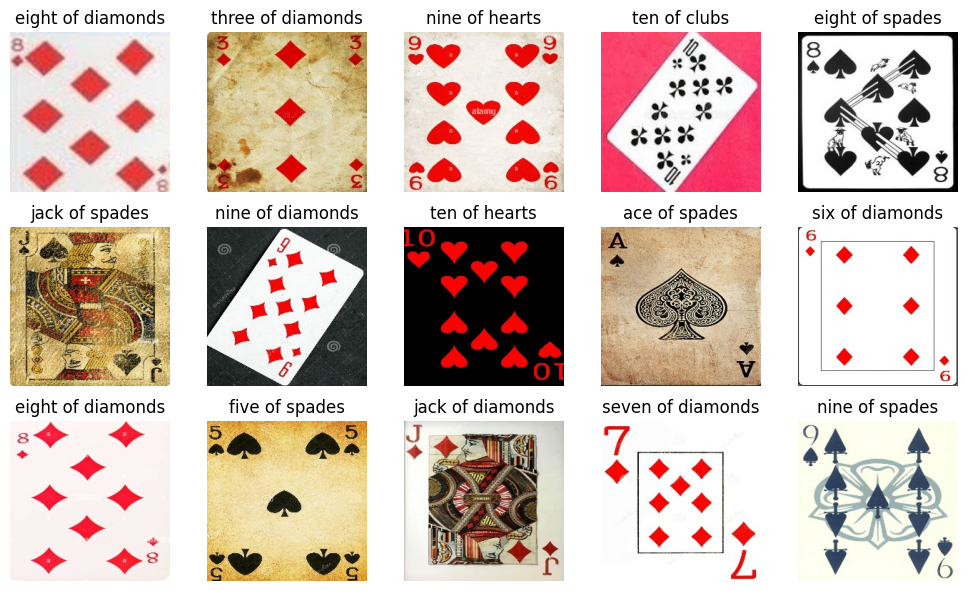

In [ ]:
train_filepaths = train_sample.filepaths.to_list()[:5]
test_filepaths = test_sample.filepaths.to_list()[:5]
valid_filepaths = valid_sample.filepaths.to_list()[:5]

image_filepaths = train_filepaths + test_filepaths + valid_filepaths
image_files = [os.path.join(data_dir, file) for file in image_filepaths]
num_images = len(image_files)
num_rows = 3
num_cols = num_images // num_rows


fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 6))
for i, image_file in enumerate(image_files):
    row = i // num_cols
    col = i % num_cols
    image = plt.imread(image_file)
    axs[row, col].imshow(image)
    axs[row, col].set_title(image_file.split("/")[-2])
    axs[row, col].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
labels = os.listdir(os.path.join(data_dir, 'train'))
labels = sorted(labels)
print(labels)

['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']


In [ ]:
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

image_path = image_files[0]
image_np = plt.imread(image_path)
image = Image.fromarray(image_np)
augmented_image = transform(image)
augmented_image.show()

from torchvision import datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

In [ ]:
import torchvision.transforms as transforms
import torch
from torchvision import datasets

# ImageNet-like normalization (common practice)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    #transforms.ColorJitter(
     #   brightness=0.2,
      #  contrast=0.2,
       # saturation=0.2,
        #hue=0.1
    #),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


In [ ]:
from torch.utils.data import DataLoader

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=valid_dir, transform=val_transform)
test_dataset  = datasets.ImageFolder(root=test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)#, num_workers=2)

# Check the number of classes:
print("Number of classes in train_dataset:", len(train_dataset.classes))  # Should be 53

#indices = list(range(40))
#subset_train_dataset = torch.utils.data.Subset(train_dataset, indices)
#subset_loader = DataLoader(subset_train_dataset, batch_size=4, shuffle=True)


Number of classes in train_dataset: 53


In [ ]:
from torch import nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinTransformer(
    img_size=224,
    patch_size=4,
    in_chans=3,
    num_classes=53,             # <--- set to 53
    embed_dim=96,               # base dimension
    depths=[2,2,6,2],           # typical for Swin-Tiny
    num_heads=[3,6,12,24],      # typical for Swin-Tiny
    window_size=7,
    mlp_ratio=4.,
    use_shift=True,
)

model = model.to(device)


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)

# Let's say we do 30 epochs total:
epochs = 30

# Cosine annealing scheduler:
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

# If you want a warm-up scheduler, you'd need a more elaborate scheme,
# e.g., using a LambdaLR that increments LR from 0 -> 1e-3 over first few epochs.
# We'll keep it simple here.


In [ ]:
best_val_acc = 0.0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Update LR scheduler (if using CosineAnnealingLR)
    scheduler.step()

    # ----- Validation -----
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = 100.0 * correct / total
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss   = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_swin_model.pt")


Epoch [1/30] Train Loss: 3.4890, Val Loss: 3.0876, Val Acc: 7.92%
Epoch [2/30] Train Loss: 3.1179, Val Loss: 2.8411, Val Acc: 13.58%
Epoch [3/30] Train Loss: 2.8859, Val Loss: 2.6088, Val Acc: 20.00%
Epoch [4/30] Train Loss: 2.6824, Val Loss: 2.5422, Val Acc: 19.62%
Epoch [5/30] Train Loss: 2.5080, Val Loss: 2.3168, Val Acc: 26.42%
Epoch [6/30] Train Loss: 2.3842, Val Loss: 2.0807, Val Acc: 33.58%
Epoch [7/30] Train Loss: 2.2480, Val Loss: 2.0435, Val Acc: 36.60%
Epoch [8/30] Train Loss: 2.1523, Val Loss: 1.8436, Val Acc: 42.26%
Epoch [9/30] Train Loss: 2.0599, Val Loss: 1.6933, Val Acc: 41.13%
Epoch [10/30] Train Loss: 1.9704, Val Loss: 1.6579, Val Acc: 44.91%
Epoch [11/30] Train Loss: 1.8916, Val Loss: 1.6062, Val Acc: 46.42%
Epoch [12/30] Train Loss: 1.8190, Val Loss: 1.5536, Val Acc: 50.19%
Epoch [13/30] Train Loss: 1.7431, Val Loss: 1.4993, Val Acc: 52.83%
Epoch [14/30] Train Loss: 1.6600, Val Loss: 1.5421, Val Acc: 56.23%
Epoch [15/30] Train Loss: 1.6026, Val Loss: 1.5612, Val Ac

In [ ]:
# Load best weights
model.load_state_dict(torch.load("best_swin_model.pt"))
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = outputs.max(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = 100.0 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


<ipython-input-53-e275f0dad736>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_swin_model.pt"))


Test Accuracy: 3.40%


In [ ]:
print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))
print("Train classes:", train_dataset.classes)

Train samples: 7624
Val samples: 265
Test samples: 265
Train classes: ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two 

In [ ]:
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)        # (batch_size, 3, 224, 224)
print("Batch labels:", labels)

Batch shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([31,  6, 13,  0,  3, 32, 12, 43, 14, 34, 19, 41, 38, 15, 19, 34, 28, 16,
        21, 23, 42,  8, 30,  1, 26, 44,  2, 40, 26, 46,  6,  8])


In [ ]:
from collections import Counter

counts = Counter([s[1] for s in train_dataset.samples])
print(counts)

Counter({3: 181, 19: 172, 2: 171, 16: 171, 18: 168, 36: 165, 30: 163, 32: 162, 29: 161, 17: 160, 5: 159, 11: 158, 40: 158, 44: 158, 12: 157, 51: 155, 52: 155, 14: 154, 28: 154, 46: 153, 6: 152, 37: 152, 24: 151, 42: 151, 8: 150, 35: 143, 48: 142, 41: 141, 15: 140, 31: 139, 38: 139, 4: 138, 9: 138, 10: 136, 7: 135, 22: 135, 27: 133, 50: 133, 49: 130, 1: 129, 26: 129, 43: 129, 21: 128, 39: 127, 45: 126, 23: 125, 25: 124, 34: 124, 0: 120, 20: 115, 13: 114, 47: 113, 33: 108})


dd